In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import shutil

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from torchinfo import summary

from models.deepLOB.deepLOB_model import Deeplob
from utils.preprocessing_v2 import create_windows, generate_labels, normalize_features, add_features
from utils.training import train_validate # train, validate
from utils.loader import LOBDataset
from utils.evaluation import evaluate
from utils.plots import plot_training_history, plot_label_distributions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
destination = 'data/crypto/'
if not os.path.exists(destination) or len(os.listdir(destination)) == 0:
    path = kagglehub.dataset_download("martinsn/high-frequency-crypto-limit-order-book-data")
    shutil.copytree(path, destination)

In [5]:
DATA_PATH = './data/crypto/BTC_1sec.csv'

BATCH_SIZE = 128 # 32
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 'y_20'
LABEL_ALPHA = 2e-5 #1e-5

LEARNING_RATE = 1e-4
# ADAM_B1 = 0.9
# ADAM_B2 = 0.999
# WEIGHT_DECAY= 5e-5 # 1e-5

In [20]:
data_df = pd.read_csv(DATA_PATH, index_col=0)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030728 entries, 0 to 1030727
Columns: 155 entries, system_time to asks_market_notional_14
dtypes: float64(154), object(1)
memory usage: 1.2+ GB


In [21]:
data_df = data_df[:300000]#.copy()
data_df['system_time'] = pd.to_datetime(data_df['system_time'])
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2021-04-10 22:53:24.234644+00:00,59201.815,0.01,56.734080,784.727275,-8.445687e-08,-7.187280e-05,-0.000089,-0.000090,-0.000092,...,0.0,0.0,0.0,0.0,0.0,8.97,0.0,0.0,0.0,0.0
299996,2021-04-10 22:53:25.234644+00:00,59196.365,0.01,27.861364,0.000000,-8.446465e-08,-6.165919e-06,-0.000053,-0.000060,-0.000176,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
299997,2021-04-10 22:53:26.234644+00:00,59196.365,0.01,47.755488,0.000000,-8.446465e-08,-6.165919e-06,-0.000060,-0.000073,-0.000160,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
299998,2021-04-10 22:53:27.234644+00:00,59196.365,0.01,0.000000,0.000000,-8.446465e-08,-6.165919e-06,-0.000060,-0.000176,-0.000260,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [22]:
meta_features = ['system_time', 'midpoint', 'spread', 'buys', 'sells']
distance_features = [f"{side}_distance_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
notional_features = [f"{side}_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
cancel_notional_features = [f"{side}_cancel_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
limit_notional_features = [f"{side}_limit_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
market_notional_features = [f"{side}_market_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]

midpoint_delta_features = ['midpoint_delta']

In [23]:
data_df = data_df[meta_features + distance_features + notional_features]
data_df = generate_labels(data_df, HORIZONS, alpha=LABEL_ALPHA)
# data_df = add_features(data_df)
data_df = normalize_features(data_df)
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_notional_5,asks_notional_6,asks_notional_7,asks_notional_8,asks_notional_9,y_10,y_20,y_30,y_50,y_100
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,0.560360,0.560360,0.560332,0.560222,0.560199,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,0.560360,0.560360,0.560332,0.560222,0.560199,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,0.560360,0.560360,0.560332,0.560222,0.560199,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,0.560360,0.560360,0.560332,0.560222,0.560199,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,0.560360,0.560360,0.560332,0.560222,0.560199,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2021-04-10 22:53:24.234644+00:00,59201.815,0.01,56.734080,784.727275,0.592018,0.591976,0.591966,0.591965,0.591964,...,0.000918,0.002901,0.004915,0.038096,0.118429,1,1,1,1,1
299996,2021-04-10 22:53:25.234644+00:00,59196.365,0.01,27.861364,0.000000,0.591964,0.591960,0.591932,0.591928,0.591859,...,0.118404,0.000918,0.038473,0.118415,0.059446,1,1,1,1,1
299997,2021-04-10 22:53:26.234644+00:00,59196.365,0.01,47.755488,0.000000,0.591964,0.591960,0.591928,0.591921,0.591869,...,0.118404,0.034083,0.038474,0.118415,0.001083,1,1,1,1,1
299998,2021-04-10 22:53:27.234644+00:00,59196.365,0.01,0.000000,0.000000,0.591964,0.591960,0.591928,0.591859,0.591809,...,0.038088,0.118404,0.020016,0.005920,0.020018,1,1,1,1,1


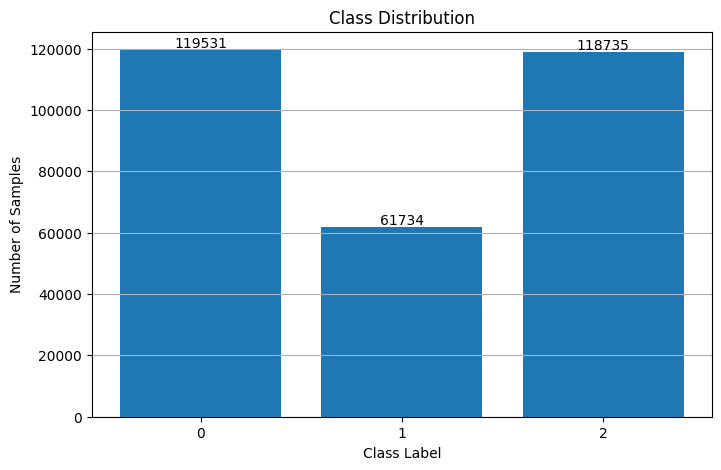

In [24]:
y_val_labels = np.array(data_df[TARGET_HORIZON])
class_counts = np.bincount(y_val_labels)

class_labels = [0, 1, 2]

plt.figure(figsize=(8,5))
plt.bar(class_labels, class_counts)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(class_labels)
plt.grid(axis='y')

for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

In [25]:
feature_cols = [col for col in data_df.columns if col not in meta_features and not col.startswith('y_')]

X = data_df[feature_cols].values
y = data_df[TARGET_HORIZON].values

X.shape, y.shape

((300000, 40), (300000,))

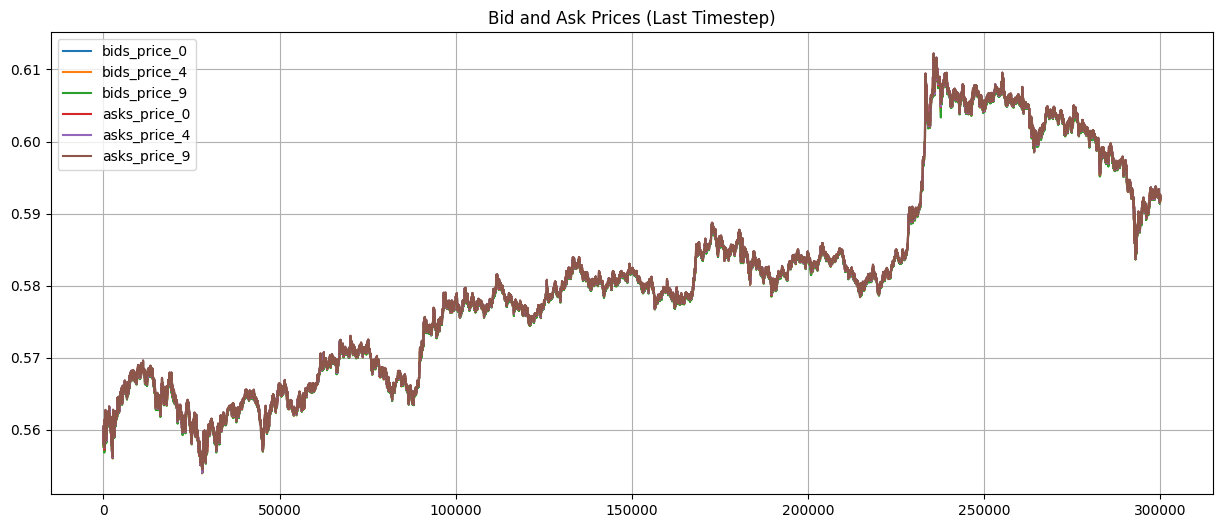

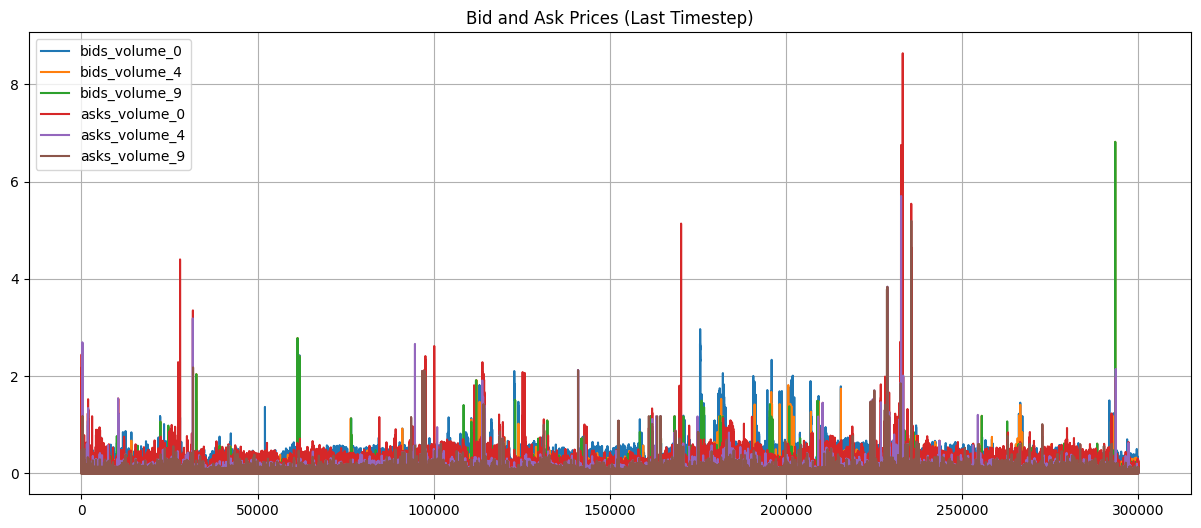

In [28]:
s = 0
l = len(X)

X_plot = X[s:s+l]  # or use `next(iter(train_loader))` for a batch
df_plot = pd.DataFrame(X_plot, columns=[f'feature_{i}' for i in range(X_plot.shape[1])])

price_levels = 10
features = []
for i in range(price_levels):
    features.append(f'bids_price_{i}')
for i in range(price_levels):
    features.append(f'asks_price_{i}')
for i in range(price_levels):
    features.append(f'bids_volume_{i}')
for i in range(price_levels):
    features.append(f'asks_volume_{i}')
    
df_plot.columns = features

bid_price_cols = ['bids_price_0', 'bids_price_4', 'bids_price_9']
ask_price_cols = ['asks_price_0', 'asks_price_4', 'asks_price_9']

plt.figure(figsize=(15, 6))
for col in bid_price_cols:
    plt.plot(df_plot[col].values, label=col)
for col in ask_price_cols:
    plt.plot(df_plot[col].values, label=col)
plt.title('Bid and Ask Prices (Last Timestep)')
plt.legend()
plt.grid()
plt.show()

bid_price_cols = ['bids_volume_0', 'bids_volume_4', 'bids_volume_9']
ask_price_cols = ['asks_volume_0', 'asks_volume_4', 'asks_volume_9']

plt.figure(figsize=(15, 6))
for col in bid_price_cols:
    plt.plot(df_plot[col].values, label=col)
for col in ask_price_cols:
    plt.plot(df_plot[col].values, label=col)
plt.title('Bid and Ask Prices (Last Timestep)')
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(df_plot['feature_0'], label='feature_0 (bid_1_price)')
# # plt.plot(df_plot['feature_39'], label='feature_39 (ask_10_vol)')
# plt.legend()
# plt.title("LOB Features over Samples")
# plt.grid()
# plt.show()

In [29]:
X_windows, y_labels = create_windows(X, y, WINDOW_SIZE)
X_windows.shape

(299900, 100, 40)

In [35]:
train_size = int(0.8 * len(X_windows))

X_train, y_train = X_windows[:train_size], y_labels[:train_size]
X_val, y_val = X_windows[train_size:], y_labels[train_size:]

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, 
#     test_size=0.1, 
#     random_state=42, 
#     shuffle=True
# )

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
# print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (239920, 100, 40), (239920,)
Validation shape: (59980, 100, 40), (59980,)


In [36]:
train_dataset = LOBDataset(X_train, y_train, True)
val_dataset = LOBDataset(X_val, y_val, True)
# test_dataset = LOBDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(next(iter(train_loader))[0].shape)

torch.Size([128, 1, 100, 40])


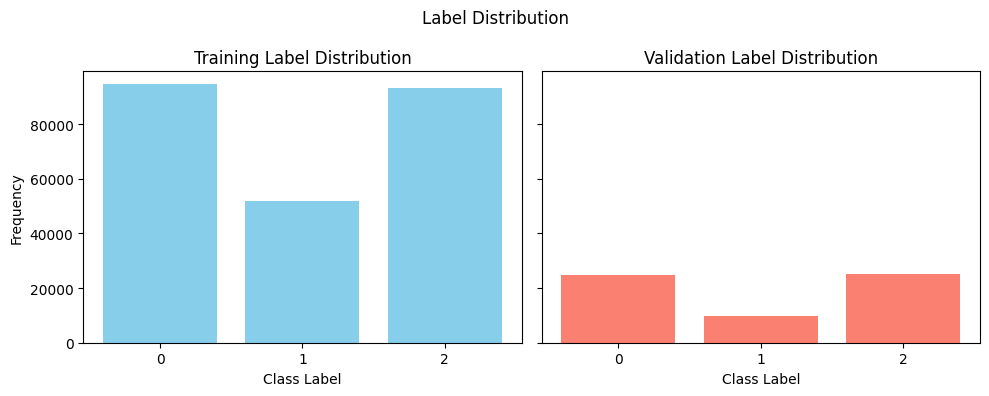

In [39]:
plot_label_distributions(train_dataset, val_dataset)

In [40]:
model_deepLOB = Deeplob().to(device)
summary(model_deepLOB, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
Deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [ ]:
epochs = 10
learning_rate = 1e-3

normalization="DecPre"
k=4
dataset_type="crypto"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepLOB.parameters(), lr=LEARNING_RATE)

history = train_validate(model_deepLOB, train_loader, val_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

Epoch 1/10, Train Loss: 1.0305, Train Acc: 0.4800, Validation Loss: 1.0253, Validation Acc: 0.4816
Epoch 2/10, Train Loss: 1.0044, Train Acc: 0.5125, Validation Loss: 1.0169, Validation Acc: 0.4885
Epoch 3/10, Train Loss: 0.9869, Train Acc: 0.5368, Validation Loss: 1.0255, Validation Acc: 0.4828
Epoch 4/10, Train Loss: 0.9533, Train Acc: 0.5822, Validation Loss: 1.0456, Validation Acc: 0.4721
Epoch 5/10, Train Loss: 0.9047, Train Acc: 0.6388, Validation Loss: 1.0612, Validation Acc: 0.4606


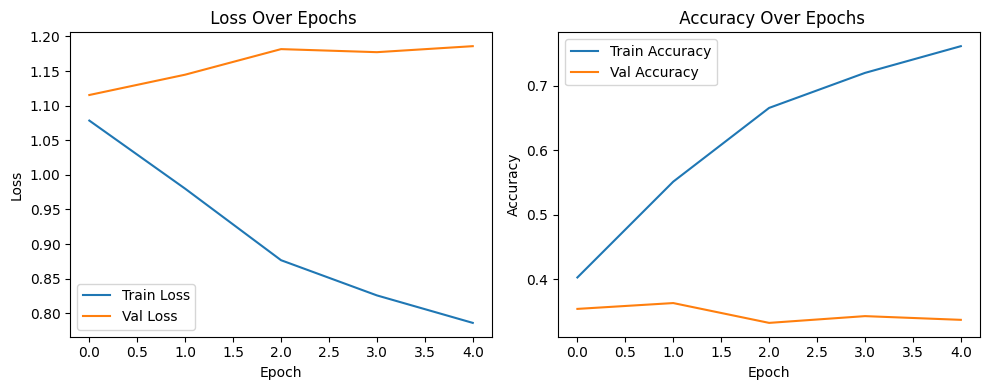

In [22]:
plot_training_history(history)

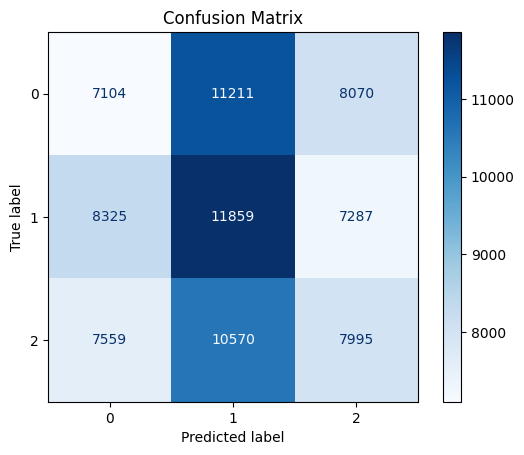

              precision    recall  f1-score   support

           0     0.3090    0.2692    0.2878     26385
           1     0.3525    0.4317    0.3881     27471
           2     0.3424    0.3060    0.3232     26124

    accuracy                         0.3371     79980
   macro avg     0.3346    0.3357    0.3330     79980
weighted avg     0.3349    0.3371    0.3338     79980

Test Accuracy: 0.3371
Test Precision (macro): 0.3346
Test Recall (macro): 0.3357
Test F1 Score (macro): 0.3330


In [24]:
evaluate(model_deepLOB, val_loader, device)